In [0]:
# !nvidia-smi

In [3]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 645kB 8.7MB/s 
     |████████████████████████████████| 1.1MB 24.7MB/s 
     |████████████████████████████████| 890kB 61.6MB/s 
     |████████████████████████████████| 3.8MB 52.5MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/154-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [7]:
import json, warnings, shutil
from scripts_step_lr_schedulers import *
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/aux/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_1.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_2.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_3.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_4.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_5.tar.gz'

,textID,text,selected_text,sentiment,jaccard,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_valid.npy
fold_1/x_valid_aux.npy
fold_1/y_train_mask.npy
fold_1/x_train_aux.npy
fold_1/x_valid.npy
fold_1/x_valid_aux2.npy
fold_1/y_valid_aux.npy
fold_1/y_train.npy
fold_1/y_train_aux.npy
fold_1/y_valid_mask.npy
fold_1/x_train.npy
fold_1/x_train_aux2.npy
fold_2/
fold_2/y_valid.npy
fold_2/x_valid_aux.npy
fold_2/y_train_mask.npy
fold_2/x_train_aux.npy
fold_2/x_valid.npy
fold_2/x_valid_aux2.npy
fold_2/y_valid_aux.npy
fold_2/y_train.npy
fold_2/y_train_aux.npy
fold_2/y_valid_mask.npy
fold_2/x_train.npy
fold_2/x_train_aux2.npy
fold_3/
fold_3/y_valid.npy
fold_3/x_valid_aux.npy
fold_3/y_train_mask.npy
fold_3/x_train_aux.npy
fold_3/x_valid.npy
fold_3/x_valid_aux2.npy
fold_3/y_valid_aux.npy
fold_3/y_train.npy
fold_3/y_train_aux.npy
fold_3/y_valid_mask.npy
fold_3/x_train.npy
fold_3/x_train_aux2.npy


# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 4,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": None,
  "question_size": 4,
  "N_FOLDS": 3,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1.98e-06


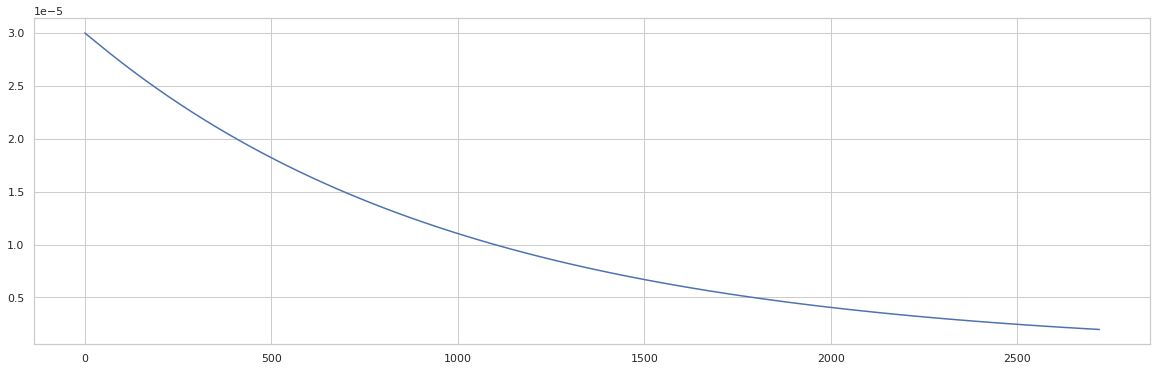

In [11]:
lr_min = 1e-6
lr_max = config['LEARNING_RATE']
step_size = len(k_fold[k_fold['fold_1'] == 'train']) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
decay = .999

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=1, lr_start=lr_max, lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_mask = layers.Dropout(.1)(last_hidden_state)
    x_mask = layers.Dense(1)(x_mask)
    x_mask = layers.Flatten()(x_mask)
    y_mask = layers.Activation('sigmoid', name='y_mask')(x_mask)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=y_mask)
    
    return model

In [0]:
def get_training_dataset(x_train, y_train, batch_size, buffer_size, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 'attention_mask': x_train[1]}, 
                                                  {'y_mask': y_train}))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size, repeated=False, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 'attention_mask': x_valid[1]}, 
                                                  {'y_mask': y_valid}))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_test_dataset(x_test, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices({'input_ids': x_test[0], 'attention_mask': x_test[1]})
    dataset = dataset.batch(batch_size)
    return dataset

# Train

In [16]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
history_list = []

threshold = .5
get_start = lambda x: np.where(x > threshold)[0][0] if (len(np.where(x > threshold)[0]) > 0) else 0
get_end = lambda x: np.where(x > threshold)[0][-1] if (len(np.where(x > threshold)[0]) > 0) else config['MAX_LEN']

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train_mask.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid_mask.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss = loss_fn(y['y_mask'], probabilities)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss = loss_fn(y['y_mask'], probabilities)
            # update metrics
            valid_loss.update_state(loss)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=1, lr_start=lr_max, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))
    loss_fn = losses.binary_crossentropy

    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'val_loss': valid_loss}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         (MODEL_BASE_PATH + model_path), save_last=False)
    
    history_list.append(history)
    model.save_weights(MODEL_BASE_PATH +'last_' + model_path)
    # model.load_weights(MODEL_BASE_PATH + model_path)

    
    # Make predictions
    train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE']))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = np.apply_along_axis(get_start, -1, train_preds[0])
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = np.apply_along_axis(get_end, -1, train_preds[0])
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = np.apply_along_axis(get_start, -1, valid_preds[0])
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = np.apply_along_axis(get_end, -1, valid_preds[0])

    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train for 687 steps, validate for 171 steps

EPOCH 1/4
time: 273.6s loss: 0.0806 val_loss: 0.0616

EPOCH 2/4
time: 262.2s loss: 0.0608 val_loss: 0.0617

EPOCH 3/4
time: 262.4s loss: 0.0558 val_loss: 0.0607

EPOCH 4/4
time: 262.2s loss: 0.0525 val_loss: 0.0621
Training finished

FOLD: 2
Train for 687 steps, validate for 171 steps

EPOCH 1/4
time: 274.0s loss: 0.0869 val_loss: 0.0630

EPOCH 2/4
time: 263.2s loss: 0.0601 val_loss: 0.0594

EPOCH 3/4
time: 263.2s loss: 0.0559 val_loss: 0.0639

EPOCH 4/4
time: 263.1s loss: 0.0520 val_loss: 0.0642
Training finished

FOLD: 3
Train for 687 steps, validate for 171 steps

EPOCH 1/4
time: 274.5s loss: 0.0944 val_loss: 0.0632

EPOCH 2/4
time: 262.7s loss: 0.0612 val_loss: 0.0623

EPOCH 3/4
time: 262.7s loss: 0.0575 val_loss: 0.0603

EPOCH 4/4
time: 262.6s loss: 0.0553 val_loss: 0.0613
Training finished


# Model loss graph

In [0]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [19]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric/Jaccard,,,,,,,,,
Overall,0.420923,0.196249,0.224674,0.419928,0.202577,0.421012,0.140526,0.421830,0.245645
Sentiment negative,0.274858,0.151851,0.123007,0.271710,0.162275,0.275033,0.117105,0.277832,0.176174
Sentiment neutral,0.645883,0.251289,0.394594,0.646545,0.250166,0.645817,0.176174,0.645287,0.327526
Sentiment positive,0.261962,0.165204,0.096757,0.260788,0.177443,0.262191,0.115563,0.262906,0.202607
0 <= text wordCnt < 3,0.845842,0.502326,0.343515,0.847319,0.644279,0.845646,0.101545,0.844560,0.761155
3 <= text wordCnt < 10,0.634511,0.302950,0.331560,0.635446,0.312722,0.631687,0.216138,0.636399,0.379991
10 <= text wordCnt < 30,0.291604,0.129254,0.162351,0.290630,0.125834,0.292891,0.103955,0.291293,0.157972
30 <= text wordCnt < 100,0.214732,0.113811,0.100921,0.212618,0.091961,0.218756,0.075140,0.212823,0.174332
0 <= selected text wordCnt < 3,0.169734,0.140134,0.029601,0.169807,0.167705,0.168880,0.081068,0.170516,0.171629


# Visualize predictions

In [20]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,sooo sad,1.000000,sooo sad i will miss you here in san,0.222222,sooo sad i will miss you here in san,0.222222
2,my boss is bullying me...,bullying me,negative,0.166667,my boss is bullying me...,0.166667,bullying me...,0.333333,my boss is bullying me...,0.166667
3,what interview! leave me alone,leave me alone,negative,0.600000,what interview! leave me alone,0.600000,leave me alone,1.000000,what interview! leave me alone,0.600000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,"sons of ****, why couldn`t they put",0.428571,"sons of ****, why couldn`t they put",0.428571,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,http://www.dothebouncy.,0.000000,http://www.dothebouncy.,0.000000,http://www.dothebouncy.,0.000000
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,2am feedings for the baby are fun when,0.125000,2am feedings for the baby are fun when,0.125000,2am feedings for the baby are fun when,0.125000
7,soooo high,soooo high,neutral,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,both of you,1.000000,,0.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,journey!? wow... u just became cooler.,0.833333,.. u just,0.333333,journey!? wow... u just became cooler.,0.833333
